### Cell 1: Setup - Getting Our libraries Ready

In [ ]:

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom,
                                     RandomContrast, RandomBrightness, BatchNormalization)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

print("All libraries are imported and ready to go!")

TensorFlow Version: 2.19.0
✅ All libraries are imported and ready to go!


### Cell 2: Connect to Drive


In [ ]:
drive.mount('/content/drive')


print("\nGrabbing the dataset from your Google Drive and moving it locally...")
drive_path = '/content/drive/MyDrive/Colab_Datasets/brain-tumor-mri-dataset'
local_path = '/content/brain-tumor-mri-dataset'

if os.path.exists(local_path):
    shutil.rmtree(local_path)

# And... copy!
shutil.copytree(drive_path, local_path)
print("Ready.")

Mounted at /content/drive

Grabbing the dataset from your Google Drive and moving it locally...
✅ Awesome! The data is now on the local drive. Training will be way faster.


### Cell 3: Loading and Prepping the Data Info

In [ ]:
train_dir = os.path.join(local_path, 'Training')
test_dir = os.path.join(local_path, 'Testing')

train_csv_path = os.path.join(train_dir, '_annotations.csv')
test_csv_path = os.path.join(test_dir, '_annotations.csv')

# Let's load up the CSV files.
col_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']
train_df = pd.read_csv(train_csv_path, header=None, names=col_names)
test_df = pd.read_csv(test_csv_path, header=None, names=col_names)

train_df['filepath'] = train_df['filename'].apply(lambda file: os.path.join(train_dir, file))
test_df['filepath'] = test_df['filename'].apply(lambda file: os.path.join(test_dir, file))

labels = sorted(train_df['class'].unique().tolist())
label_map = {label: i for i, label in enumerate(labels)}
NUM_CLASSES = len(labels)

train_df['label_encoded'] = train_df['class'].map(label_map)
test_df['label_encoded'] = test_df['class'].map(label_map)

val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index)

# Let's take a quick look at what I have got.
print(f"We have {NUM_CLASSES} classes: {labels}")
print(f"\nImages for training: {len(train_df)}")
print(f"Images for validation: {len(val_df)}")
print(f"Images for testing: {len(test_df)}")

We have 4 classes: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

Images for training: 1374
Images for validation: 343
Images for testing: 250


### Cell 4: Building the Data Pipeline for Feature Extraction

In [ ]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def parse_image(filepath, label):
    """This little function just loads and prepares a single image."""
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    # Here we use the ResNet50-specific preprocessing function.
    img = preprocess_input(img)
    return img, label

def build_dataset(df):
    """This function builds a data pipeline for feature extraction."""
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label_encoded'].values))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_extract_ds = build_dataset(train_df)
val_extract_ds = build_dataset(val_df)
test_extract_ds = build_dataset(test_df)

print("Data pipelines for feature extraction  ready!")

✅ Data pipelines for feature extraction are ready!


### Cell 5: Step 1 - Extract Bottleneck Features

In [ ]:

print("Loading the ResNet50 base model...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False

feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

print("Extracting features from the training set... (This might take a minute)")
# This gets all the feature vectors from our training images.
train_features = feature_extractor.predict(train_extract_ds)
train_labels = np.concatenate([y for x, y in train_extract_ds], axis=0)

print("Extracting features from the validation set...")
val_features = feature_extractor.predict(val_extract_ds)
val_labels = np.concatenate([y for x, y in val_extract_ds], axis=0)

print("Extracting features from the test set...")
test_features = feature_extractor.predict(test_extract_ds)
test_labels = np.concatenate([y for x, y in test_extract_ds], axis=0)

print("\n Feature extraction complete!")
print("Shape of training features:", train_features.shape)
print("Shape of training labels:", train_labels.shape)

Loading the ResNet50 base model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features from the training set... (This might take a minute)
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step
Extracting features from the validation set...
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 527ms/step
Extracting features from the test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step

✅ Feature extraction complete!
Shape of training features: (1374, 2048)
Shape of training labels: (1374,)


### Cell 6: Step 2 - Train the Custom Head

In [ ]:
#our custom head, identical to the one we built before.
head_model = Sequential([
    Dense(512, activation='relu', input_shape=(train_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

head_model.compile(optimizer=Adam(learning_rate=1e-3),
                   loss='sparse_categorical_crossentropy', # Note: sparse loss because our labels are integers
                   metrics=['accuracy'])

print(" Training the custom head in isolation ")

# Calculate class weights for our training labels.
class_labels_for_weights = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels_for_weights,
    y=train_labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

history_head = head_model.fit(
    train_features,
    train_labels,
    epochs=100,
    validation_data=(val_features, val_labels),
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

print("\nCustom head is trained!")

--- Training the custom head in isolation ---
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7267 - loss: 0.9562 - val_accuracy: 0.8280 - val_loss: 0.5809
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9132 - loss: 0.2539 - val_accuracy: 0.9155 - val_loss: 0.2318
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9472 - loss: 0.1524 - val_accuracy: 0.9271 - val_loss: 0.1853
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9477 - loss: 0.1326 - val_accuracy: 0.9213 - val_loss: 0.1916
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0949 - val_accuracy: 0.9388 - val_loss: 0.1745
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9639 - loss: 0.0967 - val_accuracy: 0.9329 - val_loss: 0.1527
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9689 - loss: 0.0882 - val_accuracy: 0.9446 - val_loss: 0.1564
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9803 - loss: 0.0661 - val_accuracy: 0.9417 - val_loss: 0.

### Cell 7: Step 3 - Rebuild and Final Fine-Tuning

In [ ]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = True
for layer in base_model.layers[:-35]:
    layer.trainable = False

# Create the full model.
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False).
x = GlobalAveragePooling2D()(x)
=for layer in head_model.layers:
    x = layer(x)
full_model = Model(inputs, x)

optimizer = Adam(learning_rate=1e-5)
full_model.compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

print("Starting final fine-tuning of the full model")

# We need a new data pipeline that has one-hot encoded labels for this step.
def build_final_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label_encoded'].values))
    dataset = dataset.map(lambda x,y: (parse_image(x,y)[0], tf.one_hot(y, depth=NUM_CLASSES)))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_final_ds = build_final_dataset(train_df)
val_final_ds = build_final_dataset(val_df)

# Let's train for just a few more epochs to gently adjust the weights.
history_final = full_model.fit(
    train_final_ds,
    epochs=20,
    validation_data=val_final_ds,
    class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

print("\n--- All training is complete! ---")

--- Starting final fine-tuning of the full model ---
Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 532ms/step - accuracy: 0.9219 - loss: 0.2096 - val_accuracy: 0.9446 - val_loss: 0.1406
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9904 - loss: 0.0391 - val_accuracy: 0.9475 - val_loss: 0.1379
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.9985 - loss: 0.0161 - val_accuracy: 0.9563 - val_loss: 0.1426
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.9563 - val_loss: 0.1449
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9504 - val_loss: 0.1481
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.9534 - val_loss: 0.1533
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9534 - val_loss: 0.1543

--- All training is complete! ---


### Cell 8: The Final reacll everything

In [ ]:

print("--- Evaluating the final model on the test data ---")
test_final_ds = build_final_dataset(test_df)
test_loss, test_acc = full_model.evaluate(test_final_ds)

print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

print("\nGetting the model's predictions...")
predictions = full_model.predict(test_final_ds)
y_pred = np.argmax(predictions, axis=1)

y_true = np.concatenate([y for x, y in test_final_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

--- Evaluating the final model on the test data ---
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.9249 - loss: 0.2295

Final Test Accuracy: 92.00%
Final Test Loss: 0.2523

Getting the model's predictions...
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 650ms/step


### Cell 9: Confusion Matrix

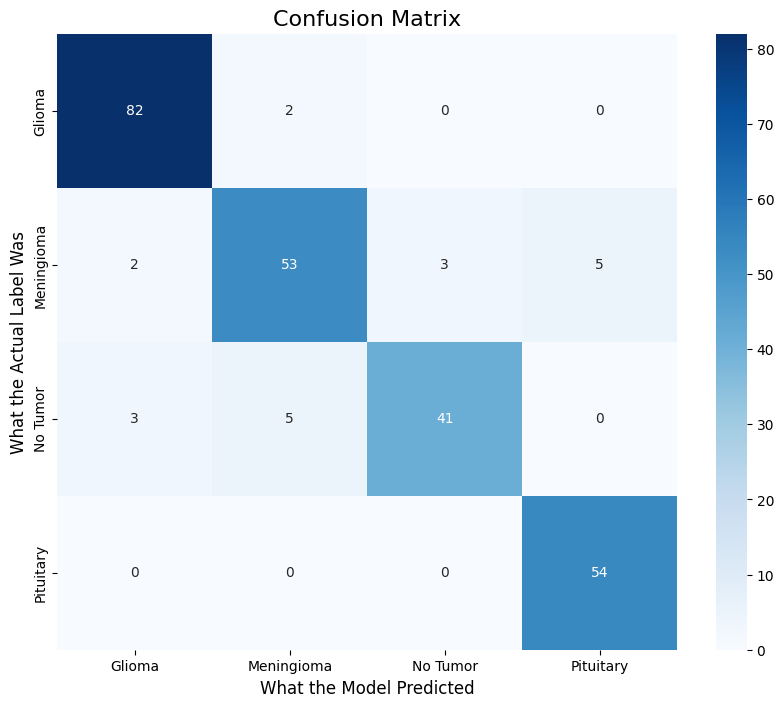

In [ ]:


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('What the Model Predicted', fontsize=12)
plt.ylabel('What the Actual Label Was', fontsize=12)
plt.show()

### Cell 10: Classification Report

In [ ]:


print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60 + "\n")
print(classification_report(y_true, y_pred, target_names=labels))


           CLASSIFICATION REPORT

              precision    recall  f1-score   support

      Glioma       0.94      0.98      0.96        84
  Meningioma       0.88      0.84      0.86        63
    No Tumor       0.93      0.84      0.88        49
   Pituitary       0.92      1.00      0.96        54

    accuracy                           0.92       250
   macro avg       0.92      0.91      0.91       250
weighted avg       0.92      0.92      0.92       250



### Cell 11: Visualizing Final Scores

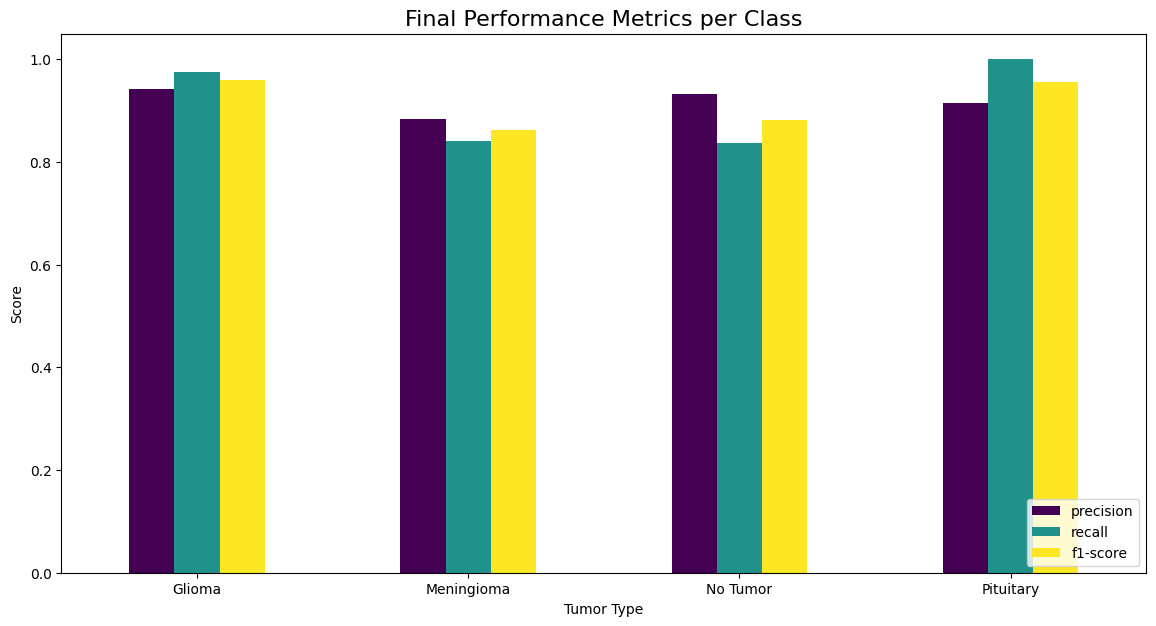

In [ ]:

try:
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    # We just want to plot the scores for each class, not the averages.
    report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

    report_df.plot(y=['precision', 'recall', 'f1-score'],
                   kind='bar',
                   figsize=(14, 7),
                   colormap='viridis')

    plt.title('Final Performance Metrics per Class', fontsize=16)
    plt.xlabel('Tumor Type')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.show()
except Exception as e:
    print(f"Could not generate the metrics plot. The classification report might be missing values.")
    print(f"Error: {e}")

Extra cell accuracy cehck

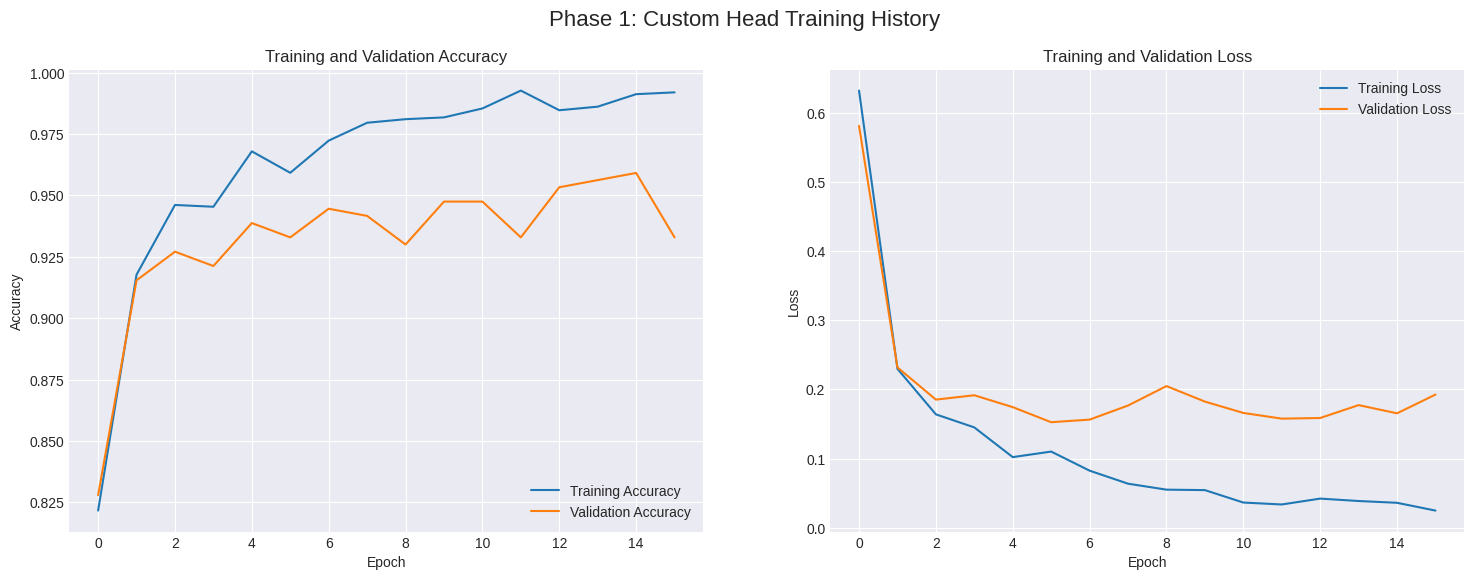

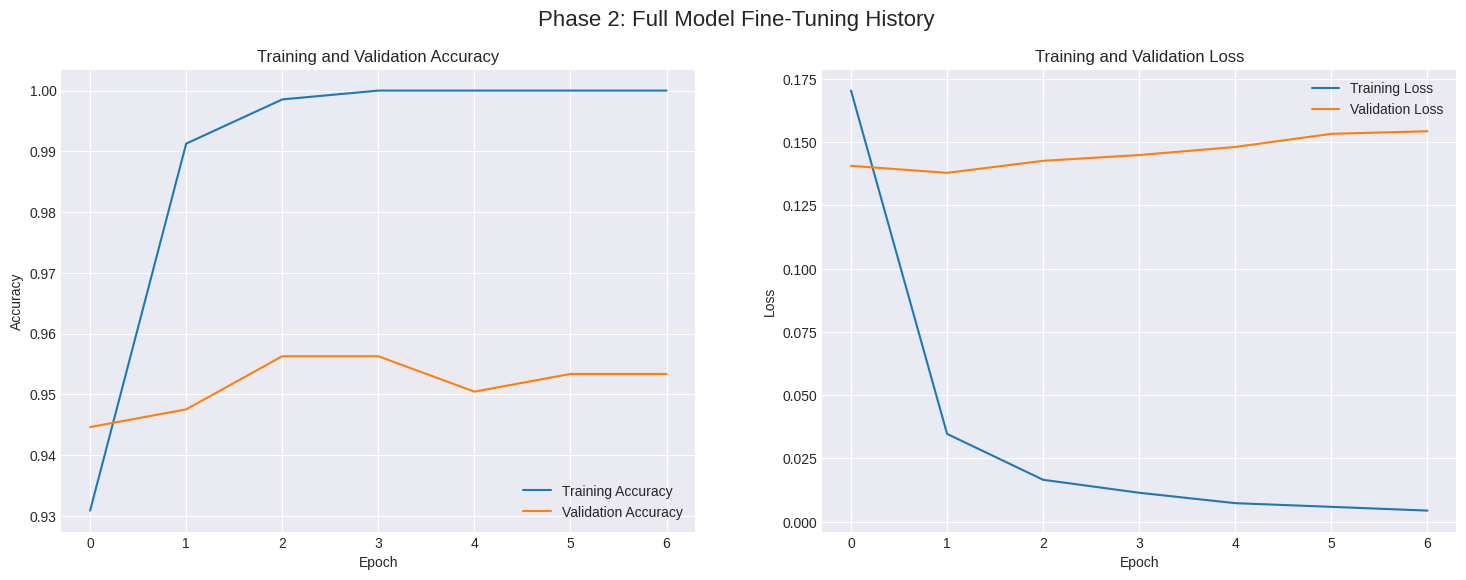

In [ ]:


def plot_history(history, title):
    """A helper function to plot the training history."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    # Plot Accuracy
    ax1.plot(epochs_range, acc, label='Training Accuracy')
    ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    # Plot Loss
    ax2.plot(epochs_range, loss, label='Training Loss')
    ax2.plot(epochs_range, val_loss, label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')

    plt.show()

# Plot the history for the first training phase (training the head)
plot_history(history_head, 'Phase 1: Custom Head Training History')

# Plot the history for the second training phase (fine-tuning the full model)
plot_history(history_final, 'Phase 2: Full Model Fine-Tuning History')